# Import libraries

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import numpy as np
import pandas as pd 
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1.0)
sns.set(style='darkgrid')

import missingno as msno
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


# Exploratory Data Analysis

In [2]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-dec-2021/train.csv")
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


In [3]:
train_df.shape

(4000000, 56)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 56 columns):
 #   Column                              Dtype
---  ------                              -----
 0   Id                                  int64
 1   Elevation                           int64
 2   Aspect                              int64
 3   Slope                               int64
 4   Horizontal_Distance_To_Hydrology    int64
 5   Vertical_Distance_To_Hydrology      int64
 6   Horizontal_Distance_To_Roadways     int64
 7   Hillshade_9am                       int64
 8   Hillshade_Noon                      int64
 9   Hillshade_3pm                       int64
 10  Horizontal_Distance_To_Fire_Points  int64
 11  Wilderness_Area1                    int64
 12  Wilderness_Area2                    int64
 13  Wilderness_Area3                    int64
 14  Wilderness_Area4                    int64
 15  Soil_Type1                          int64
 16  Soil_Type2                          

In [5]:
train_df.Cover_Type.unique()

array([1, 2, 3, 6, 7, 4, 5])

In [6]:
for col in train_df.columns:
    msg = 'column: {:>10}\t Percent of NAN value: {:.2f}%'.format(col, 100 * (train_df[col].isnull().sum()/train_df[col].shape[0]))
    print(msg)

column:         Id	 Percent of NAN value: 0.00%
column:  Elevation	 Percent of NAN value: 0.00%
column:     Aspect	 Percent of NAN value: 0.00%
column:      Slope	 Percent of NAN value: 0.00%
column: Horizontal_Distance_To_Hydrology	 Percent of NAN value: 0.00%
column: Vertical_Distance_To_Hydrology	 Percent of NAN value: 0.00%
column: Horizontal_Distance_To_Roadways	 Percent of NAN value: 0.00%
column: Hillshade_9am	 Percent of NAN value: 0.00%
column: Hillshade_Noon	 Percent of NAN value: 0.00%
column: Hillshade_3pm	 Percent of NAN value: 0.00%
column: Horizontal_Distance_To_Fire_Points	 Percent of NAN value: 0.00%
column: Wilderness_Area1	 Percent of NAN value: 0.00%
column: Wilderness_Area2	 Percent of NAN value: 0.00%
column: Wilderness_Area3	 Percent of NAN value: 0.00%
column: Wilderness_Area4	 Percent of NAN value: 0.00%
column: Soil_Type1	 Percent of NAN value: 0.00%
column: Soil_Type2	 Percent of NAN value: 0.00%
column: Soil_Type3	 Percent of NAN value: 0.00%
column: Soil_Ty

In [7]:
train_df['Cover_Type'].value_counts()

2    2262087
1    1468136
3     195712
7      62261
6      11426
4        377
5          1
Name: Cover_Type, dtype: int64

In [8]:
len(train_df)

4000000

In [9]:
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-dec-2021/test.csv")
test_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4000000,2763,78,20,377,88,3104,218,213,195,...,0,0,0,0,0,0,0,0,0,0
1,4000001,2826,153,11,264,39,295,219,238,148,...,0,0,0,0,0,0,0,0,0,0
2,4000002,2948,57,19,56,44,852,202,217,163,...,0,0,1,0,0,0,0,0,0,0
3,4000003,2926,119,6,158,134,2136,234,240,142,...,0,0,0,0,0,0,0,0,0,0
4,4000004,2690,10,4,38,108,3589,213,221,229,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.shape

(1000000, 55)

# Exploring features

## cover type

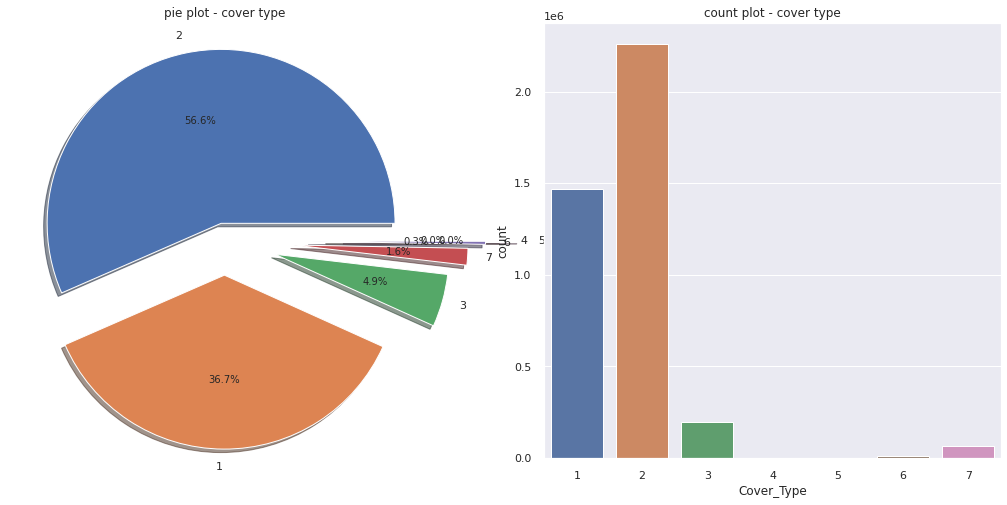

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
train_df['Cover_Type'].value_counts().plot.pie(explode=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('pie plot - cover type')
ax[0].set_ylabel('')
sns.countplot('Cover_Type', data=train_df, ax=ax[1])
ax[1].set_title('count plot - cover type')
plt.show()

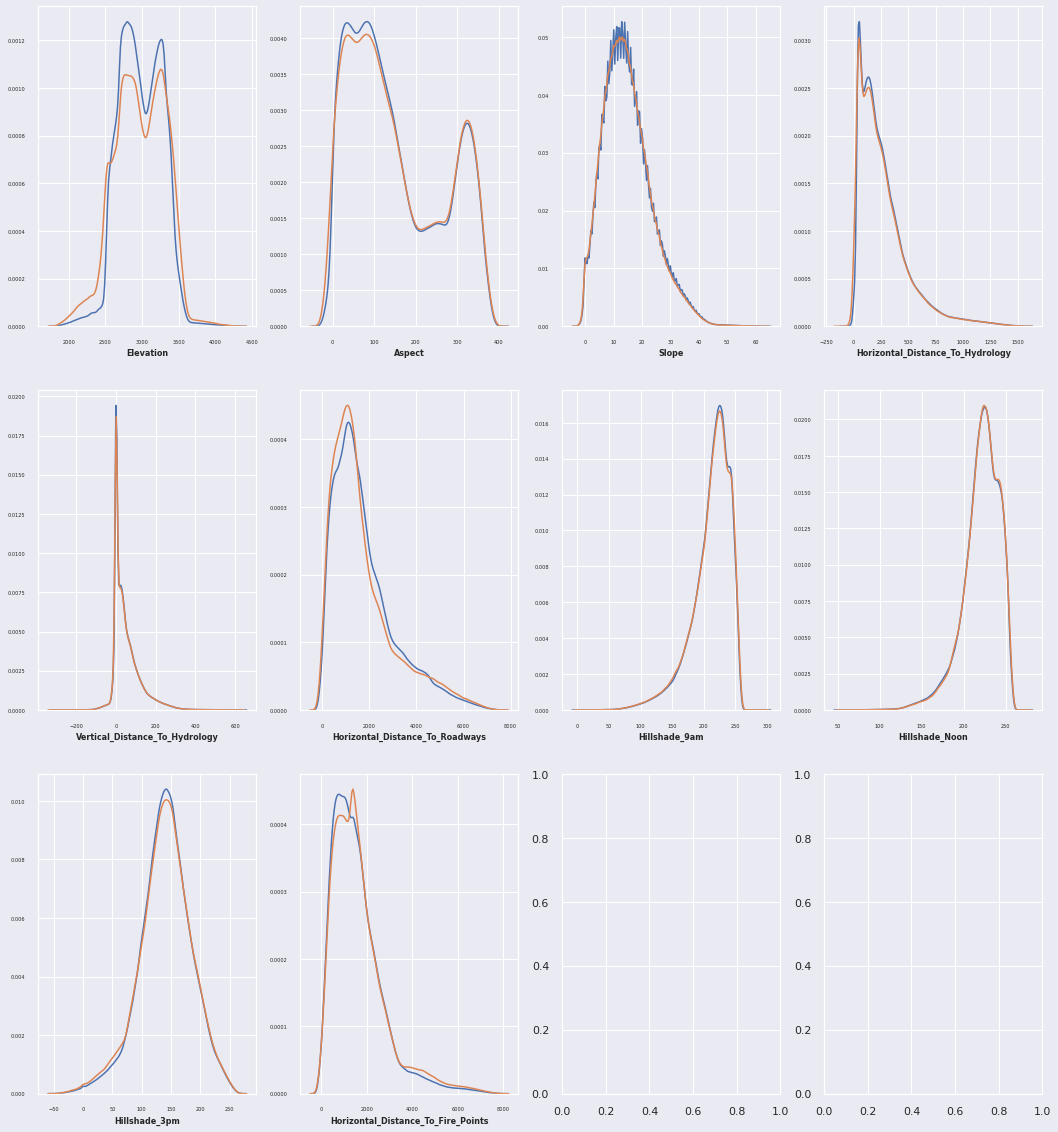

In [12]:
features = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
           'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
           'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']

ncols = 4
nrows = int(len(features) / ncols + (len(features) % ncols > 0)) 

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 20), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c >= len(features):
            break
        col = features[r*ncols+c]
        sns.kdeplot(x=train_df[col], ax=axes[r, c], label='Train data')
        sns.kdeplot(x=test_df[col], ax=axes[r, c], label='Test data')
        axes[r, c].set_ylabel('') 
        axes[r, c].set_xlabel(col, fontsize=8, fontweight='bold')
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

## Soil_Type

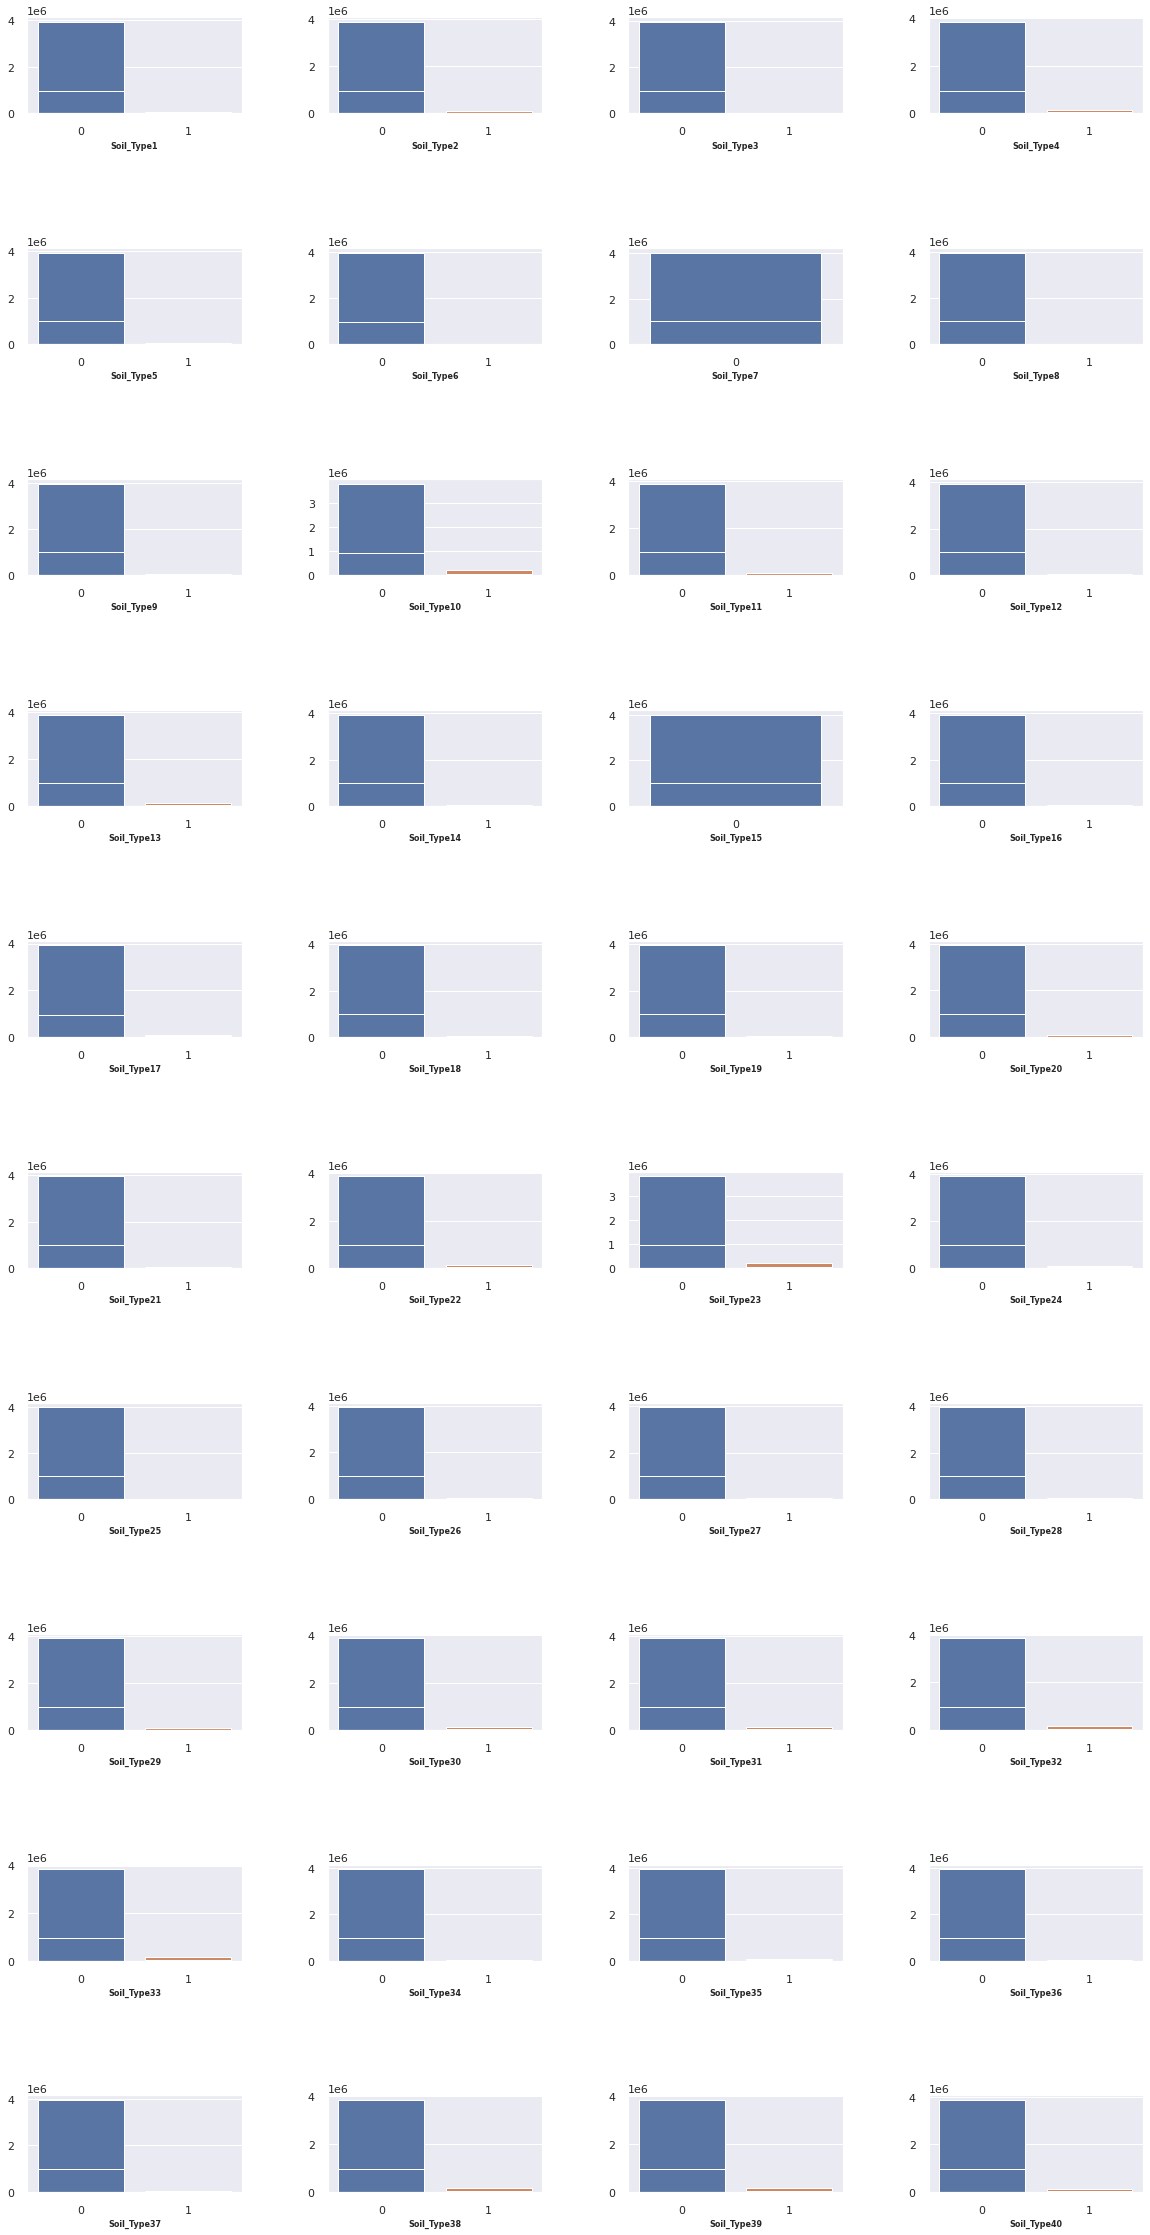

In [13]:
f, ax = plt.subplots(10, 4, figsize=(20, 40))

cnt = 0
for r in range(10):
    for c in range(0, 4): 
        cnt = cnt + 1
        sns.countplot('Soil_Type'+str(cnt), data=train_df, ax=ax[r,c], label='Train data')
        sns.countplot('Soil_Type'+str(cnt), data=test_df, ax=ax[r,c], label='Test data')
        ax[r, c].set_ylabel('') 
        ax[r, c].set_xlabel('Soil_Type'+str(cnt), fontsize=8, fontweight='bold')
plt.subplots_adjust(wspace=0.4, hspace=1.4)
plt.show()  


## Wilderness_Area

In [14]:
pd.crosstab(train_df['Wilderness_Area1'], train_df['Cover_Type'], margins=True).style.background_gradient(cmap='YlOrRd')

Cover_Type,1,2,3,4,5,6,7,All
Wilderness_Area1,,,,,,,,
0,1029773,1658688,195681,377,1,11425,59283,2955228
1,438363,603399,31,0,0,1,2978,1044772
All,1468136,2262087,195712,377,1,11426,62261,4000000


In [15]:
pd.crosstab(train_df['Wilderness_Area2'], train_df['Cover_Type'], margins=True).style.background_gradient(cmap='terrain_r')

Cover_Type,1,2,3,4,5,6,7,All
Wilderness_Area2,,,,,,,,
0,1381233,2187401,193664,376,1,11301,59380,3833356
1,86903,74686,2048,1,0,125,2881,166644
All,1468136,2262087,195712,377,1,11426,62261,4000000


In [16]:
pd.crosstab(train_df['Wilderness_Area3'], train_df['Cover_Type'], margins=True).style.background_gradient(cmap='YlOrRd')

Cover_Type,1,2,3,4,5,6,7,All
Wilderness_Area3,,,,,,,,
0,608005,688915,75583,377,0,8648,4179,1385707
1,860131,1573172,120129,0,1,2778,58082,2614293
All,1468136,2262087,195712,377,1,11426,62261,4000000


In [17]:
pd.crosstab(train_df['Wilderness_Area4'], train_df['Cover_Type'], margins=True).style.background_gradient(cmap='terrain_r')

Cover_Type,1,2,3,4,5,6,7,All
Wilderness_Area4,,,,,,,,
0,1468136,2259426,120129,0,1,2771,62261,3912724
1,0,2661,75583,377,0,8655,0,87276
All,1468136,2262087,195712,377,1,11426,62261,4000000


# feature engineering

## feature selection


In [18]:
# drop columns
drop_feature_names = ["Soil_Type7", "Soil_Type15"]
train_df.drop(drop_feature_names, axis=1, inplace=True)
test_df.drop(drop_feature_names, axis=1, inplace=True)

In [19]:
# categorical feature -> change type
categorical_feature_names = ["Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4"]

for var in categorical_feature_names:
    train_df[var] = train_df[var].astype("category")
    test_df[var] = test_df[var].astype("category")

In [20]:
#one hot encoding
train_df = pd.get_dummies(train_df, columns=['Wilderness_Area1'], prefix='Wilderness_Area1')
train_df = pd.get_dummies(train_df, columns=['Wilderness_Area2'], prefix='Wilderness_Area2')
train_df = pd.get_dummies(train_df, columns=['Wilderness_Area3'], prefix='Wilderness_Area3')
train_df = pd.get_dummies(train_df, columns=['Wilderness_Area4'], prefix='Wilderness_Area4')

test_df = pd.get_dummies(test_df, columns=['Wilderness_Area1'], prefix='Wilderness_Area1')
test_df = pd.get_dummies(test_df, columns=['Wilderness_Area2'], prefix='Wilderness_Area2')
test_df = pd.get_dummies(test_df, columns=['Wilderness_Area3'], prefix='Wilderness_Area3')
test_df = pd.get_dummies(test_df, columns=['Wilderness_Area4'], prefix='Wilderness_Area4')

In [21]:
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type40,Cover_Type,Wilderness_Area1_0,Wilderness_Area1_1,Wilderness_Area2_0,Wilderness_Area2_1,Wilderness_Area3_0,Wilderness_Area3_1,Wilderness_Area4_0,Wilderness_Area4_1
0,0,3189,40,8,30,13,3270,206,234,193,...,0,1,0,1,1,0,1,0,1,0
1,1,3026,182,5,280,29,3270,233,240,106,...,0,2,0,1,1,0,1,0,1,0
2,2,3106,13,7,351,37,2914,208,234,137,...,0,1,0,1,1,0,1,0,1,0
3,3,3022,276,13,192,16,3034,207,238,156,...,0,2,0,1,1,0,1,0,1,0
4,4,2906,186,13,266,22,2916,231,231,154,...,0,2,0,1,1,0,1,0,1,0


In [22]:
selected_columns = train_df[features]
skewness_df = selected_columns.copy()

skewness = skewness_df.apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

Vertical_Distance_To_Hydrology        1.755169
Horizontal_Distance_To_Hydrology      1.750869
Horizontal_Distance_To_Fire_Points    1.552941
Horizontal_Distance_To_Roadways       1.229078
Slope                                 0.732752
Aspect                                0.498374
Elevation                            -0.063051
Hillshade_3pm                        -0.316813
Hillshade_Noon                       -1.146600
Hillshade_9am                        -1.342551
dtype: float64

In [23]:
len(skewness_df)

4000000

In [24]:
# log for skewed feature
skew_feats = skewness[skewness>1].index
log_train_df = skewness_df.copy()
log_train_df[skew_feats] = np.log1p(log_train_df[skew_feats])
log_train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,3189,40,8,3.433987,2.639057,8.092851,206,234,193,8.491670
1,3026,182,5,5.638355,3.401197,8.092851,233,240,106,8.598589
2,3106,13,7,5.863631,3.637586,7.977625,208,234,137,8.569786
3,3022,276,13,5.262690,2.833213,8.017967,207,238,156,7.961021
4,2906,186,13,5.587249,3.135494,7.978311,231,231,154,7.879670


# modeling

In [25]:
df = train_df
df[features] = log_train_df[features]
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type40,Cover_Type,Wilderness_Area1_0,Wilderness_Area1_1,Wilderness_Area2_0,Wilderness_Area2_1,Wilderness_Area3_0,Wilderness_Area3_1,Wilderness_Area4_0,Wilderness_Area4_1
0,0,3189,40,8,3.433987,2.639057,8.092851,206,234,193,...,0,1,0,1,1,0,1,0,1,0
1,1,3026,182,5,5.638355,3.401197,8.092851,233,240,106,...,0,2,0,1,1,0,1,0,1,0
2,2,3106,13,7,5.863631,3.637586,7.977625,208,234,137,...,0,1,0,1,1,0,1,0,1,0
3,3,3022,276,13,5.262690,2.833213,8.017967,207,238,156,...,0,2,0,1,1,0,1,0,1,0
4,4,2906,186,13,5.587249,3.135494,7.978311,231,231,154,...,0,2,0,1,1,0,1,0,1,0


In [26]:
del skewness_df
del train_df
del log_train_df

In [27]:
len(df)

4000000

In [28]:
df.dropna(inplace=True)

In [29]:
len(df)

3453541

In [30]:
X_train = df.drop('Cover_Type', axis=1).values
target_label = df['Cover_Type'].values

In [31]:
X_test = test_df.values

In [32]:
X_tr, X_vid, y_tr, y_vid = train_test_split(X_train, target_label, test_size=0.3, random_state=42)

In [34]:
np.any(np.isnan(X_tr)) 

False

In [35]:
np.all(np.isfinite(X_tr))

False

In [36]:
np.any(np.isnan(X_vid)) 

False

In [37]:
np.all(np.isfinite(X_vid))

False

In [38]:
print(X_tr.dtype)

float64


In [39]:
# sklearn's RandomForestClassifier silently converts the array to float32
new_X_tr = np.nan_to_num(X_tr.astype(np.float32))
print(new_X_tr.dtype)

float32


In [40]:
# sklearn's RandomForestClassifier silently converts the array to float32
new_X_vid = np.nan_to_num(X_vid.astype(np.float32))
print(new_X_vid.dtype)

float32


In [41]:
del df
del X_tr
del X_vid

In [42]:
# training with random forest
# model = RandomForestClassifier()

# start_time = time.time()
# model.fit(new_X_tr, y_tr)   
# print("%s seconds" % (time.time() - start_time))

1785.9926433563232 seconds


In [5]:
# training with LGBMRegressor
params = {'num_iterations': 10**5}       
model = LGBMRegressor(**params)
kwargs = {}
kwargs['verbose'] = False
kwargs['eval_set'] = [(X_vid, y_vid)]
kwargs['early_stopping_rounds'] = 100
   
start_time = time.time()    
model.fit(new_X_tr, y_tr, **kwargs)
print("%s seconds" % (time.time() - start_time))

NameError: name 'X_vid' is not defined

In [43]:
# prediction
prediction = model.predict(new_X_vid)

In [44]:
prediction

array([1, 2, 2, ..., 3, 2, 2])

In [45]:
print('total {}, {:.2f}% accuracy'.format(y_vid.shape[0], 100 * metrics.accuracy_score(prediction, y_vid)))

total 1036063, 95.60% accuracy


In [46]:
model.feature_importances_

array([1.94886671e-02, 6.72687734e-01, 1.26996912e-02, 1.09038402e-02,
       1.89248846e-02, 2.35747747e-02, 5.05161414e-02, 1.22607567e-02,
       1.21026046e-02, 1.27408639e-02, 3.11703723e-02, 5.09962214e-04,
       1.69937452e-03, 4.79276381e-04, 1.16643734e-03, 5.33390002e-04,
       7.03816958e-04, 2.37740874e-04, 8.63775796e-04, 4.48322292e-03,
       1.94799519e-03, 1.21198697e-03, 2.03411467e-03, 1.25029271e-03,
       1.30243334e-03, 1.54485714e-03, 1.14465915e-03, 1.20629094e-03,
       1.44512221e-03, 1.07782694e-03, 2.72379681e-03, 2.45057843e-03,
       1.96602475e-03, 3.23537289e-04, 1.27748187e-03, 1.08945720e-03,
       1.00631797e-03, 3.91353168e-04, 1.39557285e-03, 2.07807519e-03,
       1.90289074e-03, 2.60682809e-03, 1.19701609e-03, 2.09608606e-03,
       1.48068951e-03, 1.72611141e-03, 4.55248231e-03, 5.81611209e-03,
       3.64859176e-03, 3.55310773e-03, 3.87667611e-03, 1.24379765e-03,
       1.12734452e-03, 5.88203682e-03, 5.32007685e-03, 1.58563453e-02,
      

In [47]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=test_df.columns)

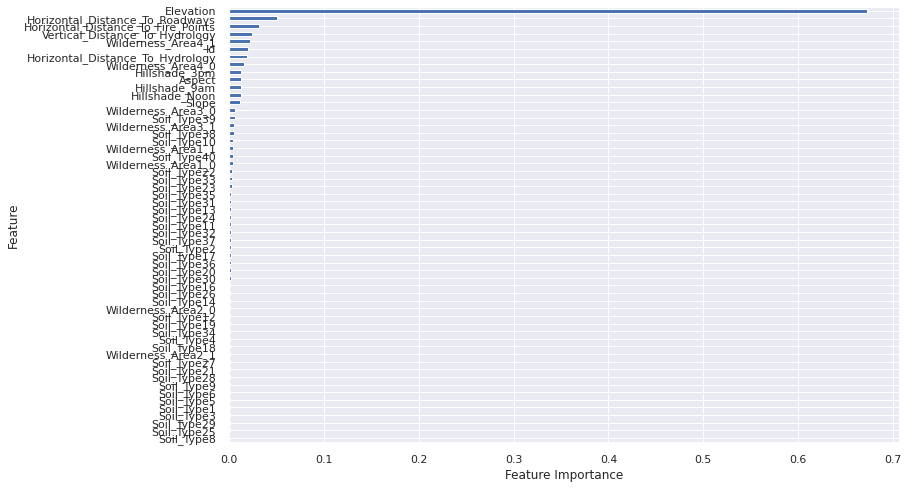

In [48]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# submission

In [49]:
sample_df = pd.read_csv("/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv")
sample_df.head(20)

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
5,4000005,2
6,4000006,2
7,4000007,2
8,4000008,2
9,4000009,2


In [50]:
prediction = model.predict(X_test)

In [51]:
sample_df['Cover_Type'] = prediction

In [52]:
sample_df.to_csv('./submission.csv', index=False)

In [53]:
sample_df.head(20)

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
5,4000005,3
6,4000006,2
7,4000007,1
8,4000008,2
9,4000009,2
